# Importing Libraries

In [9]:
import numpy as np
import pandas as pd
import os
import cv2
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
from skimage.io import imread


In [ ]:
# https://drive.google.com/file/d/1BFFPLdvDK-9YYVHjpOwVavmPBlTYPeHr/view?usp=sharing
# ! gdown --id 1BFFPLdvDK-9YYVHjpOwVavmPBlTYPeHr
# !unzip TB.zip

In [ ]:
data_dir = Path('TB')
data_dir

PosixPath('TB')

# Reading Data

In [ ]:
normal_cases_dir = data_dir / 'normal'
Tuberculosis_cases_dir = data_dir / 'tuberculosis'
normal_cases = normal_cases_dir.glob('*.txt')
Tuberculosis_cases = Tuberculosis_cases_dir.glob('*.txt')

train_data = []

for img in normal_cases:
    train_data.append((img,0))

for img in Tuberculosis_cases:
    train_data.append((img, 1))

train_data = pd.DataFrame(train_data, columns=['image', 'label'],index=None)
train_data = train_data.sample(frac=1.).reset_index(drop=True)
train_data.head()

,image,label
0,TB/tuberculosis/302.txt,1
1,TB/normal/249.txt,0
2,TB/normal/2086.txt,0
3,TB/normal/1788.txt,0
4,TB/normal/2061.txt,0


In [ ]:
train_data.shape

(4200, 2)

0    3500
1     700
Name: label, dtype: int64


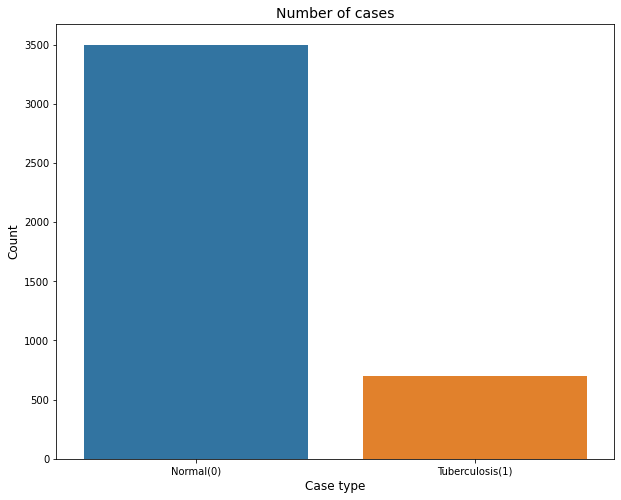

In [ ]:
cases_count = train_data['label'].value_counts()
print(cases_count)

plt.figure(figsize=(10,8))
sns.barplot(x=cases_count.index, y= cases_count.values)
plt.title('Number of cases', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(cases_count.index)), ['Normal(0)', 'Tuberculosis(1)'])
plt.show()

# Converting text files to image 

In [ ]:
from tqdm import tqdm
train_normal = data_dir / 'normal'
train_Tuberculosis = data_dir / 'tuberculosis'

normal_cases = normal_cases_dir.glob('*.txt')
Tuberculosis_cases =Tuberculosis_cases_dir.glob('*.txt')
train_data =[]
train_labels =[]
from keras.utils.np_utils import to_categorical 

img_size = 28

for file in tqdm(normal_cases):
    # print(file)
    loaded_arr = np.loadtxt(file)
    normal_image = loaded_arr.reshape(loaded_arr.shape[0], loaded_arr.shape[1] // 3, 3)
    img = cv2.resize(normal_image, (img_size,img_size))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    # # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img=np.array(img)
    img = img/255
    label = 'normal'
    train_data.append(img)
    train_labels.append(label)

for file in tqdm(Tuberculosis_cases):
    loaded_arr = np.loadtxt(file)
    tuberculosis_image = loaded_arr.reshape(loaded_arr.shape[0], loaded_arr.shape[1] // 3, 3)
    img = cv2.resize(tuberculosis_image, (img_size,img_size))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img=np.array(img)
    img = img/255
    label = 'Tuberculosis'
    train_data.append(img)
    train_labels.append(label)
    

train_data1 = np.array(train_data)
train_labels1 = np.array(train_labels)

print("Total number of validation examples: ", train_data1.shape)
print("Total number of labels:", train_labels1.shape)


3500it [07:09,  8.15it/s]
700it [01:25,  8.16it/s]


Total number of validation examples:  (4200, 28, 28, 3)
Total number of labels: (4200,)


In [ ]:
len(train_data)

4200

In [ ]:
train_labels1.shape

(4200,)

In [ ]:
train_labels1 = pd.DataFrame(train_labels1, columns=[ 'label'],index=None)
train_labels1.head()

,label
0,normal
1,normal
2,normal
3,normal
4,normal


In [ ]:
train_labels1['label']=train_labels1['label'].map({'normal':0,'Tuberculosis':1})
train_labels1['label'].unique()

array([0, 1])

# Resampling Dataset

In [ ]:
from imblearn.over_sampling import SMOTE
smt = SMOTE()
train_rows=len(train_data1)
train_data1 = train_data1.reshape(train_rows,-1)
train_data2, train_labels2 = smt.fit_resample(train_data1, train_labels1)

0    3500
1    3500
Name: label, dtype: int64


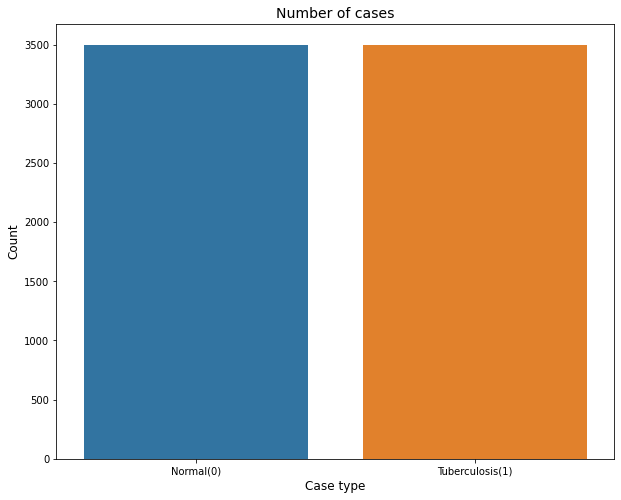

In [ ]:
cases_count1 = train_labels2['label'].value_counts()
print(cases_count1)

# Plot the results 
plt.figure(figsize=(10,8))
sns.barplot(x=cases_count1.index, y= cases_count1.values)
plt.title('Number of cases', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(cases_count.index)), ['Normal(0)', 'Tuberculosis(1)'])
plt.show()

In [ ]:
train_data2.shape

(7000, 2352)

In [ ]:
train_labels2.shape

(7000, 1)

In [ ]:
train_labels2

,label
0,0
1,0
2,0
3,0
4,0
...,...
6995,1
6996,1
6997,1
6998,1


In [ ]:
train_data2 =train_data2.reshape(-1,28,28,3)

# splitting dataset

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train_data2, train_labels2, test_size=0.15, random_state=42)

In [ ]:
print(len(X_train), len(X_test) , len(y_train) , len(y_test))

5950 1050 5950 1050


In [4]:
from tensorflow import keras
from tensorflow.keras import layers
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(28,
                                  28,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
      
  ]
)

# Creating Model 

In [5]:
import tensorflow as tf
from tensorflow.keras import  layers, models

model = models.Sequential([
    data_augmentation,
    layers.Conv2D(28, (3, 3), activation='relu', input_shape=(28, 28, 3)) ,
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu')
    
])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 28, 28, 3)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 26, 26, 28)        784       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 13, 13, 28)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 11, 11, 64)        16192     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 3, 3, 64)         

In [ ]:
model.add(layers.Flatten())
model.add(layers.Dense(640, activation='tanh'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(564, activation='tanh'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation='tanh'))
model.add(layers.Dense(64, activation='sigmoid'))
model.add(layers.Dense(2))
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 28, 28, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 128)       3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 256)       295168    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 256)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 256)        

# Training

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.fit(np.array(X_train), np.array(y_train), epochs=10, validation_data=(np.array(X_test), np.array(y_test)))

Epoch 1/10
191/191 [==============================] - 6s 24ms/step - loss: 0.5717 - accuracy: 0.6560 - val_loss: 0.2885 - val_accuracy: 0.9187
Epoch 2/10
191/191 [==============================] - 4s 23ms/step - loss: 0.2583 - accuracy: 0.8977 - val_loss: 0.2445 - val_accuracy: 0.8923
Epoch 3/10
191/191 [==============================] - 4s 22ms/step - loss: 0.2108 - accuracy: 0.9154 - val_loss: 0.1329 - val_accuracy: 0.9451
Epoch 4/10
191/191 [==============================] - 4s 23ms/step - loss: 0.1806 - accuracy: 0.9304 - val_loss: 0.1396 - val_accuracy: 0.9538
Epoch 5/10
191/191 [==============================] - 4s 23ms/step - loss: 0.1528 - accuracy: 0.9452 - val_loss: 0.0758 - val_accuracy: 0.9780
Epoch 6/10
191/191 [==============================] - 5s 27ms/step - loss: 0.1364 - accuracy: 0.9504 - val_loss: 0.0939 - val_accuracy: 0.9703
Epoch 7/10
191/191 [==============================] - 4s 23ms/step - loss: 0.1293 - accuracy: 0.9516 - val_loss: 0.1437 - val_accuracy: 0.9440

# Saving Model

In [ ]:
model.save('classificationSuppressed')
model.save('classificationSupressed.h5')

# Checking performance 

<Axes: >

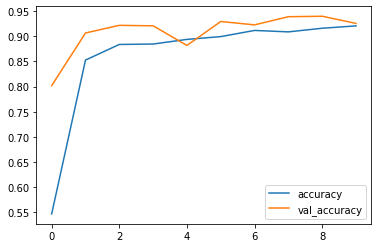

In [ ]:
training_df = pd.DataFrame(history.history)
training_df[['accuracy', 'val_accuracy']].plot()

<Axes: >

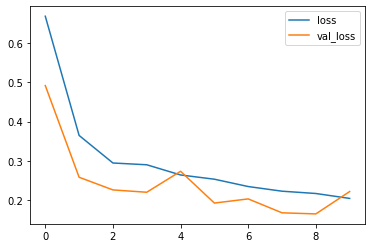

In [ ]:
training_df[['loss', 'val_loss']].plot()

In [ ]:
train_labels2['label'].unique()

array([0, 1])

# Loading model

In [87]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image
model = tf.keras.models.load_model('/Users/utkarsh/majorProject/finalModels/classificationSuppressed')
model_ae = keras.models.load_model('/Users/utkarsh/majorProject/finalModels/256AutoencoderFinal.h5')

# Predicting on random images

1/1 [==============================] - 0s 486ms/step


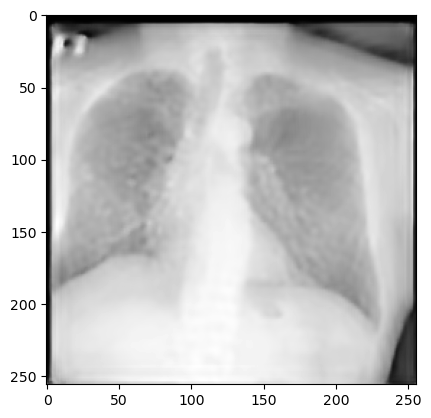

In [159]:
image='/Users/utkarsh/majorProject/TB_Chest_Radiography_Database/Tuberculosis/Tuberculosis-19.png'
img_rows = 256
img_cols = 256
img_channels = 1
img_shape = (img_rows, img_cols, img_channels)
def test(image):
    test1 = []
    test = cv2.imread(image,cv2.IMREAD_GRAYSCALE)
    test = cv2.resize(test,(img_rows,img_cols))
    test = np.array(test)/255
    test1.append(test)   
    plt.imshow(test1[0])   
    test2 = np.array(test1).reshape(-1, img_rows, img_cols, img_channels)
    return test2

test_img = test(image)
pred_img = model_ae.predict(test_img)
plt.imshow(pred_img[0],  cmap='gray')

In [160]:
test_img = tf.squeeze(test_img, axis=0)
test_img = tf.tile(test_img, multiples=[1, 1, 3])  
test_img = np.array(test_img)

In [161]:
img = cv2.resize(test_img,(28,28))
output_image = tf.expand_dims(img, axis=0)
pred = model.predict(output_image)
print(pred)
if(np.argmax(pred)):
  print("tuberculosis")
else: print("Normal")

1/1 [==============================] - 0s 74ms/step
[[-3.17281    1.9539199]]
tuberculosis
